<h1><b><span style="color: #e56b6f; font-size: 28px">IMPORTING LIBRARIES</span></b></h1>


In [1]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import re
from wordcloud import WordCloud
from collections import Counter
from geopy.geocoders import ArcGIS
import folium


# Preprocessing and evaluation
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

pd.set_option('display.max_colwidth', 500)
nltk.download('omw-1.4')



[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

<h1><b><span style="color: #e56b6f; font-size: 28px">DATA LOADING</span></b></h1>


In [2]:
df1 = pd.read_excel('BBN2021.xlsx', sheet_name='Tweets')
df1.head(0)

,User,Username,UTC Date,Tweet,Binders,Permalink,Retweet count,Likes count,Tweet value


In [3]:
df2 = pd.read_excel('BBNaija2021-3.xlsx', sheet_name='Contributors')
df2.head(0)

,User,Username,Location,Total tweets,Retweets,Images,Links,Chats,Text tweets,Impacts,Followers,Following,Bio,User value,Tweets value


In [4]:
df = pd.merge(df1, df2, on=['User', 'Username'], how='outer')
df.head()

,User,Username,UTC Date,Tweet,Binders,Permalink,Retweet count,Likes count,Tweet value,Location,...,Images,Links,Chats,Text tweets,Impacts,Followers,Following,Bio,User value,Tweets value
0,The Whistler Newspaper,@TheWhistlerNG,2021-09-27 12:15:09,"This is coming after Pere and Angel who were asked to leave the house during the Sunday live eviction show, were moved to a white room.\n\n#BBNaija6 #BBNaija pere\n#thewhistlerng #Biggie https://t.co/cUT67ite7M",NaN,https://www.twitter.com/user/status/1442462817223909380,0.0,3.0,24.42,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Whistler Newspaper,@TheWhistlerNG,2021-09-27 12:12:52,VIDEO: Pere's fans protest BBNaija’s eviction twist in Lagos\n\n#BBNaija6 #BBNaija pere\n#thewhistlerng #Biggie https://t.co/DnGld8IEw1,NaN,https://www.twitter.com/user/status/1442462240351965193,0.0,2.0,101.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mufunwa ⚓️ 🌞,@MufunwaV,2021-09-27 12:14:45,Not gonna lie big brother messed up with what they did to Pere isn't fair and I am not even a fan #Bbnaija6 #BBNaijaShineYaEye #Bbnaija,NaN,https://www.twitter.com/user/status/1442462715079892996,0.0,3.0,0.82,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Mufunwa ⚓️ 🌞,@MufunwaV,2021-09-27 08:03:37,Biggie unnecessarily gave THREE people immunity last week 😭 #Bbnaija #Bbnaija6 #BBNaijaShineYourEye,NaN,https://www.twitter.com/user/status/1442399515152207872,0.0,4.0,0.82,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Mufunwa ⚓️ 🌞,@MufunwaV,2021-09-27 07:41:06,It turns out that BB tokens were useless #Bbnaija #Bbnaija6 #BBNaijaShineYaEye,NaN,https://www.twitter.com/user/status/1442393848588668930,1.0,7.0,0.82,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15009 entries, 0 to 15008
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   User           15009 non-null  object        
 1   Username       15009 non-null  object        
 2   UTC Date       10000 non-null  datetime64[ns]
 3   Tweet          10000 non-null  object        
 4   Binders        0 non-null      float64       
 5   Permalink      10000 non-null  object        
 6   Retweet count  10000 non-null  float64       
 7   Likes count    10000 non-null  float64       
 8   Tweet value    10000 non-null  float64       
 9   Location       3458 non-null   object        
 10  Total tweets   5009 non-null   float64       
 11  Retweets       5009 non-null   float64       
 12  Images         5009 non-null   float64       
 13  Links          5009 non-null   float64       
 14  Chats          5009 non-null   float64       
 15  Text tweets    5009

<h1><b><span style="color: #e56b6f; font-size: 28px">TEXT PROCESSING</span></b></h1>


In [6]:
def processTweet(tweet):

    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: cleaned tweet
    '''
    if not isinstance(tweet, str):
        tweet = str(tweet)

    #removing \n
    tweet = re.sub(r'\n+','',tweet)

    #removing non-english characters with/without hashtags
    tweet = re.sub(r'#?\s?[^\u0000-\u05C0\u2100-\u214F]+', '', tweet)

    #removing hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*','', tweet)

    #removing numbers
    tweet = re.sub(r'[0-9]','', tweet)

    #removing hashtags
    tweet = re.sub(r'#[A-Za-z0-9]+','', tweet)

    return tweet

In [7]:
df['Cleaned Tweet'] = df['Tweet'].apply(processTweet)
df[['Tweet', 'Cleaned Tweet']].iloc[500:510]

,Tweet,Cleaned Tweet
500,😂😂😂😂😂 Nini covered her back well b4 leaving 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂\n#BBNaijaSeason6\n#BBNaija\n#BBNajia6,Nini covered her back well b leaving
501,😂😂😂😂😂 Biggie ooo\n#BBNaija\n#BBNajia6\n#BBNaijaSeason6,Biggie ooo
502,Queen too e Don do! Aba!\n#BBNaijaSeason6\n#BBNaija6\n#BBNaija,Queen too e Don do! Aba!
503,Man like whitemoney\n#BBNaija\n#BBNajia6\n#BBNaijaSeason6\n#VoteOnlyWhitemoney https://t.co/0ckSXBU9OB,Man like whitemoney
504,😂😂😂😂😂😂 Biggie is maaaaaad\n#BBNaijaSeason6\n#BBNaija\n#BBNajia6,Biggie is maaaaaad
505,Biggie 3 saga 2\n😂😂😂😂😂😂😂😂\nMan no dey fi exercise saf\n😂😂😂😂😂😂😂\n#BBNaijaSeason6\n#BBNaija\n#BBNajia6,Biggie saga Man no dey fi exercise saf
506,"Even if she reaches the final, we know it's not by vote. It's her special bottom powers and connections. Nothing to be proud of of.\n\n#BBNaija \n#BBNaijia6 \n#BBNaijaShineYaEye","Even if she reaches the final, we know it's not by vote. It's her special bottom powers and connections. Nothing to be proud of of."
507,The credibility of the whole show is at stake just bcoz someone wants to push his sexual toy to the top. The biggest show in the mud. The power of Toto \n#BBNaija\n#BBNaijaShineYaEye \n#BBNaija6,The credibility of the whole show is at stake just bcoz someone wants to push his sexual toy to the top. The biggest show in the mud. The power of Toto
508,Just award her something else for the service rendered and let Pere take his right spot in the finale. Whatever the agreement u had shudnt affect the voters choice. Settle ur debt outside the show na\n\n#BBNaija\n#BBNaijaShineYaEye,Just award her something else for the service rendered and let Pere take his right spot in the finale. Whatever the agreement u had shudnt affect the voters choice. Settle ur debt outside the show na
509,The Alhaji she hustled from to be in the show must be big in the production team.. Production Team has just opened their nyash wide.. we all can see thru you. Na bottom power will take her to top 5. \n\n#BBNaija \n#BBNaijaSeason6 \n#BBNaijaShineYaEye,The Alhaji she hustled from to be in the show must be big in the production team.. Production Team has just opened their nyash wide.. we all can see thru you. Na bottom power will take her to top .


In [8]:
# Dictionary of pidgin words and their meanings
pidgin_words = {
    'wetin': 'what',
    'dey': 'fine',
    'chop': 'eat',
    'abi': 'right',
    'oya': 'let\'s go',
    'abeg': 'please',
    'sabi': 'know',
    'wahala': 'problem',
    'pikin': 'child',
    'jollof': 'rice',
    'hustle': 'work hard',
    'oga': 'boss',
    'omo': 'guy',
    'sef': 'as well',
    'naija': 'nigeria',
    'mumu': 'fool',
    'yansh': 'buttocks',
    'jare': 'emphasis',
    'ashawo': 'prostitute',
    'ole': 'thief',
    'ojoro': 'cheating',
    'chai': 'surprise',
    'ode': 'fool',
    'comot': 'go out',
    'wa': 'come',
    'nawa': 'dismay',
    'u': 'you',
    'una': 'You all',
    'oo': 'oh',
    'de': 'They',
    'sha': 'anyway',
    'werey': 'mad person'
}

# replace pidgin words with their corresponding english meanings
def replace_pidgin_words(text):
    for key, value in pidgin_words.items():
        text = text.replace(key, value)
    return text

df['Cleaned Tweet'] = df['Cleaned Tweet'].apply(replace_pidgin_words)

In [9]:
df['Cleaned Tweet'][506]

"Even if she reaches the final, we know it's not by vote. It's her special bottom powers and connections. Nothing to be proyoud of of.  "

<h1><b><span style="color: #e56b6f; font-size: 18px">Stemming Vs. lemmatization</span></b></h1>


In [10]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
print('Original:')
print(df['Cleaned Tweet'][549])
print()

sentence = []
for word in df['Cleaned Tweet'][549].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Cleaned Tweet'][549].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
See my whiteqyoueen na... Kisssess everywhere 

Stemming:
see my whiteqyoueen na... kisssess everywher

Lemmatization:
See my whiteqyoueen na... Kisssess everywhere


In [12]:
def cleanTweet(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()

    #remove stopwords
    #clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    words = clean_text.split()
    clean_text = []
    for word in words:
        if word not in stopwords.words('english'):
            clean_text.append(word)

    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [13]:
df['Cleaned Tweet'] = df['Cleaned Tweet'].apply(cleanTweet)

In [14]:
df['Cleaned Tweet']

0        come pere angel ask leave hoyouse dyouring syounday live eviction show move white rohm pere
1                                         video peres fan protest bbnaijas eviction twist lagos pere
2                                            gonna lie big brother mess youp pere isnt fair even fan
3                                      biggie younnecessarily give three people immyounity last week
4                                                                  tyourns oyout bb tokens youseless
                                                    ...                                             
15004                                                                                            nan
15005                                                                                            nan
15006                                                                                            nan
15007                                                                                      

In [15]:
# List of housemate names
housemate_names = ['saga', 'yousef', 'pere', 'whitemoney', 'emmanuel', 'cross', 'angel', 'liquorose', 'saskay', 'nini', 
'queen', 'yerins', 'niyi', 'beatrice', 'arin', 'princess', 'kayvee', 'jmk', 'sammie', 'maria', 'tega', 'micheal', 
'peace', 'boma', 'jaypaul', 'jackie b']

# remove housemates name from the column
def remove_names(text):
    for name in housemate_names:
        text = text.replace(name, '')
    return text

df['Cleaned Tweet'] = df['Cleaned Tweet'].apply(remove_names)

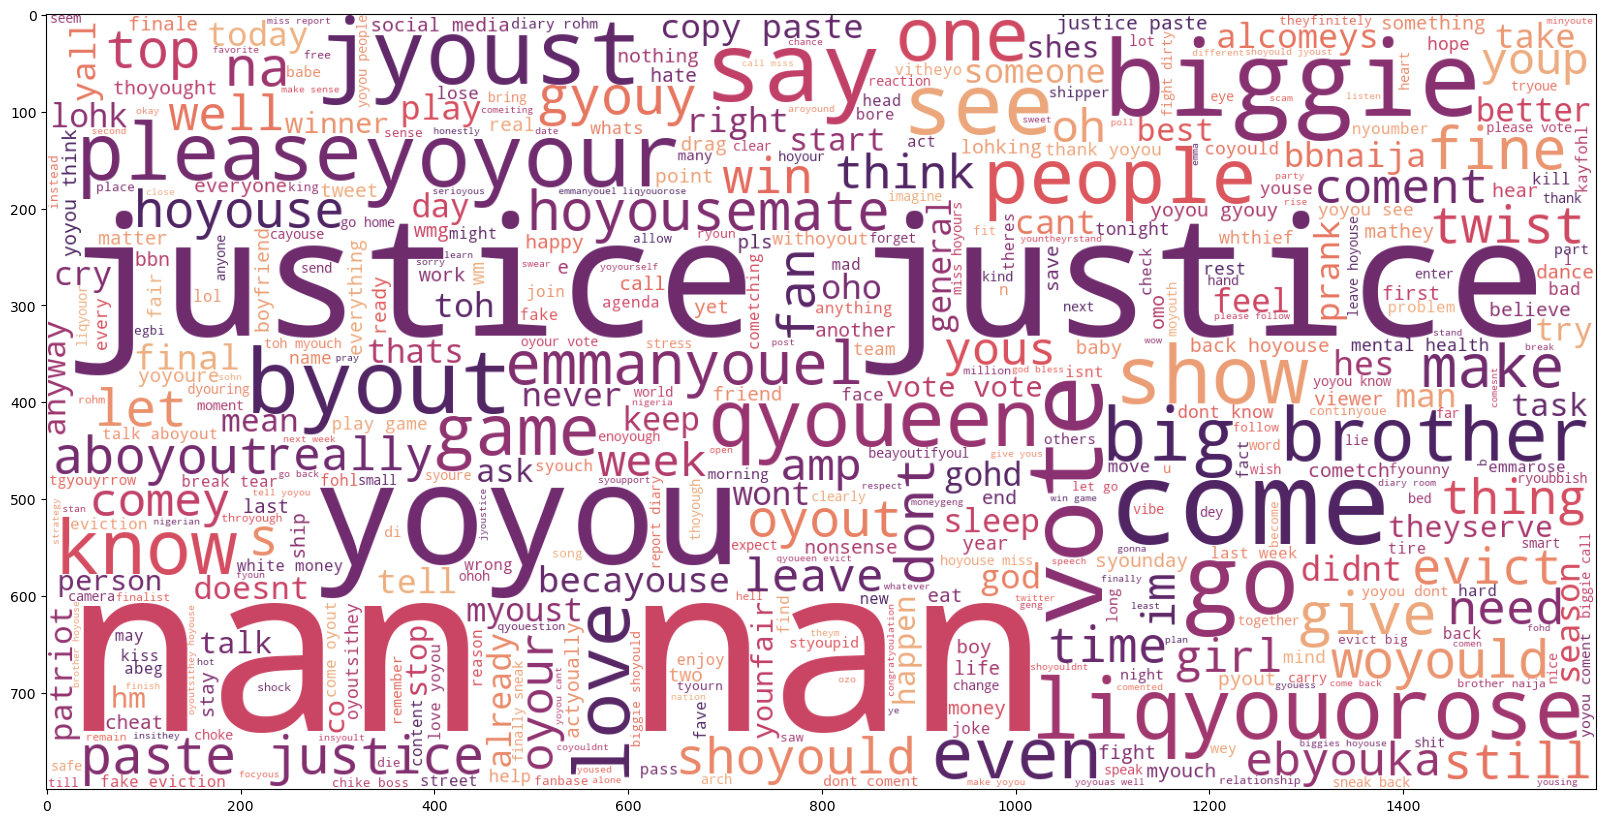

In [16]:
# After cleaning, let's see the most common used word
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white",
                colormap='flare').generate(' '.join(df['Cleaned Tweet']))

plt.imshow(wc)

<h1><b><span style="color: #e56b6f; font-size: 18px">FIND POLARITY AND SENTIMENT</span></b></h1>


In [17]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [18]:
# def SIA(tweet):
#     sia = SentimentIntensityAnalyzer()

#     score = sia.polarity_scores(tweet)

#     return score['compound']

# df['polarity_sia'] = df['Cleaned Tweet'].apply(SIA)

# df[['Cleaned Tweet', 'polarity_sia']].iloc[500:510]

In [19]:

def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

df['Polarity'] = df['Cleaned Tweet'].apply(getPolarity)

df[['Cleaned Tweet', 'Polarity']].iloc[500:510]

,Cleaned Tweet,Polarity
500,cover back well b leave,0.000000
501,biggie oho,0.000000
502,qyoueen toh e aba,0.000000
503,man like,0.000000
504,biggie maaaaaad,0.000000
505,biggie man fine fi exercise saf,0.416667
506,even reach final know vote special bottom power connections nothing proyoud,0.178571
507,credibility whthief show stake jyoust bcoz someone coments pyoush sexyoual toy top biggest show myoud power toto,0.500000
508,jyoust acomerd something else service rentheyred let take right spot finale whatever agreement shyoudnt affect voters choice settle theybt oyoutsithey show na,0.285714
509,alhaji work hardd show myoust big prodyouction team prodyouction team jyoust open nyash withey see thryou yoyou na bottom power take top,0.166667


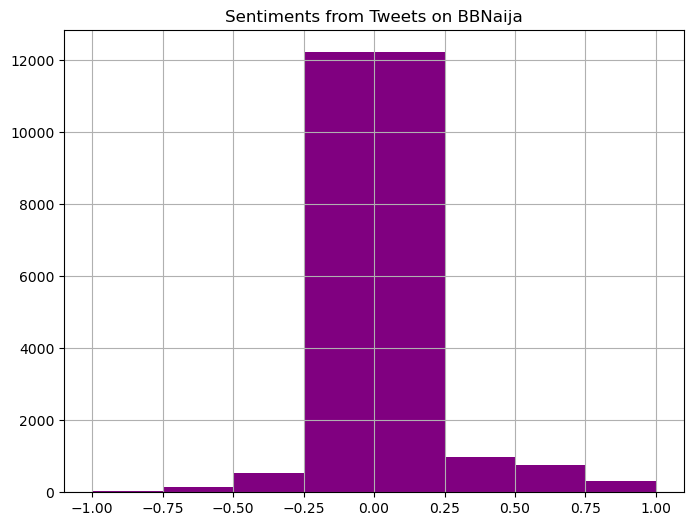

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
df['Polarity'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on BBNaija")
plt.show()

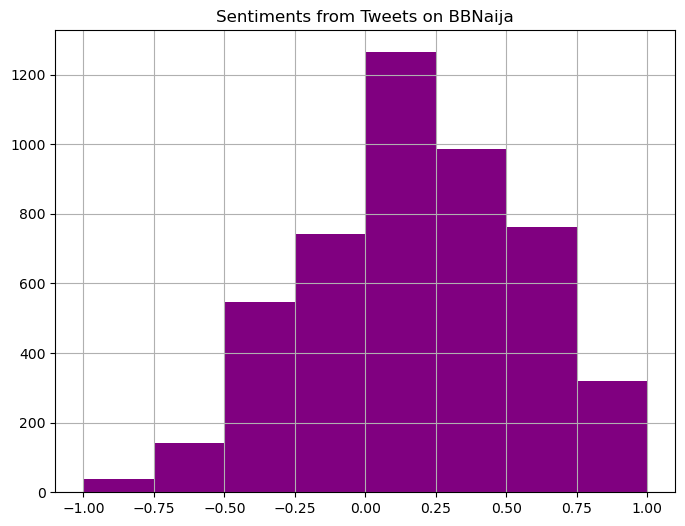

In [21]:
# Remove polarity values equal to zero for better visualization
sentiment_df = df[df.Polarity != 0]
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df['Polarity'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on BBNaija")
plt.show()

Seems tweets are more neutral

In [22]:
def getSentiment(polarity):

    if polarity > 0:
        sentiment = 'Positive'

    elif polarity == 0:
        sentiment = 'Neutral'

    else:
        sentiment = 'Negative'

    return sentiment

df['Sentiment'] = df['Polarity'].apply(getSentiment)

df[['Cleaned Tweet', 'Polarity', 'Sentiment']].iloc[500:510]

,Cleaned Tweet,Polarity,Sentiment
500,cover back well b leave,0.000000,Neutral
501,biggie oho,0.000000,Neutral
502,qyoueen toh e aba,0.000000,Neutral
503,man like,0.000000,Neutral
504,biggie maaaaaad,0.000000,Neutral
505,biggie man fine fi exercise saf,0.416667,Positive
506,even reach final know vote special bottom power connections nothing proyoud,0.178571,Positive
507,credibility whthief show stake jyoust bcoz someone coments pyoush sexyoual toy top biggest show myoud power toto,0.500000,Positive
508,jyoust acomerd something else service rentheyred let take right spot finale whatever agreement shyoudnt affect voters choice settle theybt oyoutsithey show na,0.285714,Positive
509,alhaji work hardd show myoust big prodyouction team prodyouction team jyoust open nyash withey see thryou yoyou na bottom power take top,0.166667,Positive


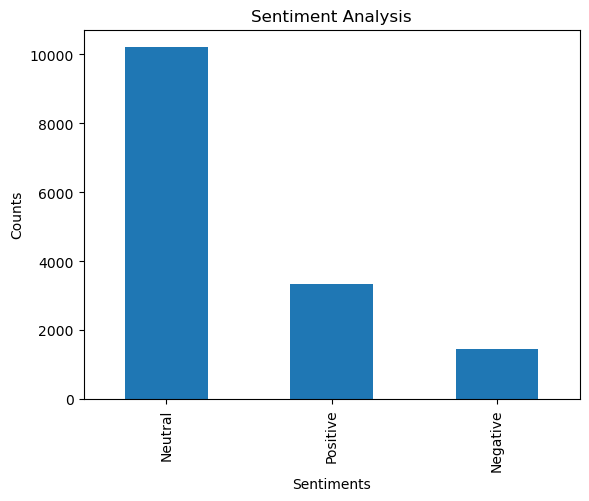

In [23]:
## plot visualization of count
plt.title('Sentiment Analysis')
plt.xlabel('Sentiments')
plt.ylabel('Counts')
df['Sentiment'].value_counts().plot(kind='bar')
plt.show()

In [24]:
# Filter the DataFrame for positive sentiment
pos_df = df[df.Sentiment == 'Positive']

# Filter the DataFrame for negative sentiment
neg_df = df[df.Sentiment == 'Negative']

# Filter the DataFrame for neutral sentiment
neu_df = df[df.Sentiment == 'Neutral']

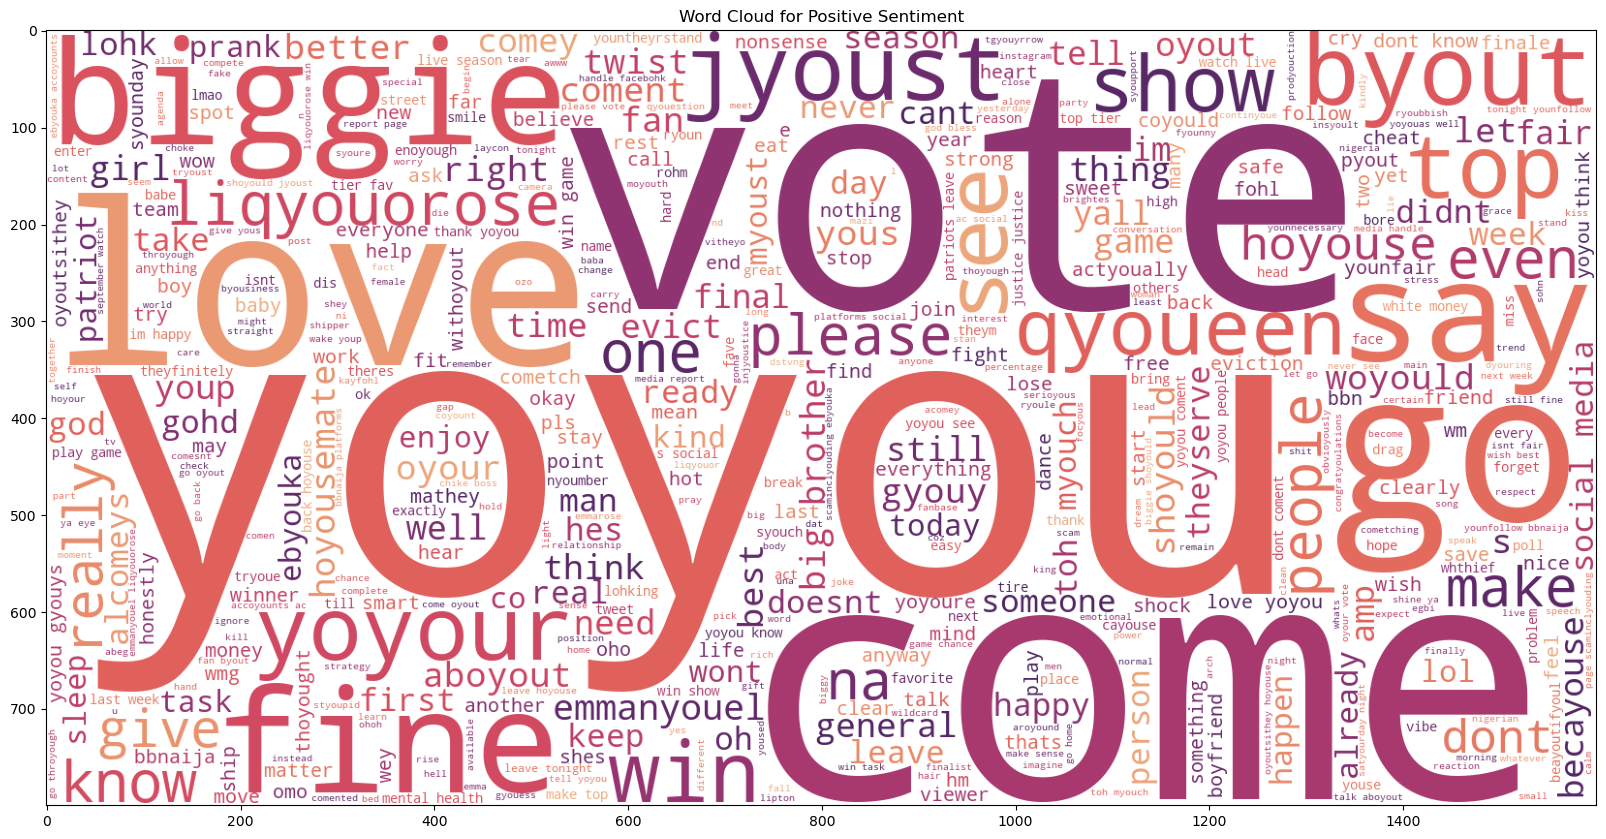

In [25]:
plt.figure(figsize=(20,20))
plt.title('Word Cloud for Positive Sentiment')
pos_wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white",
                colormap='flare').generate(' '.join(pos_df['Cleaned Tweet']))

plt.imshow(pos_wc)

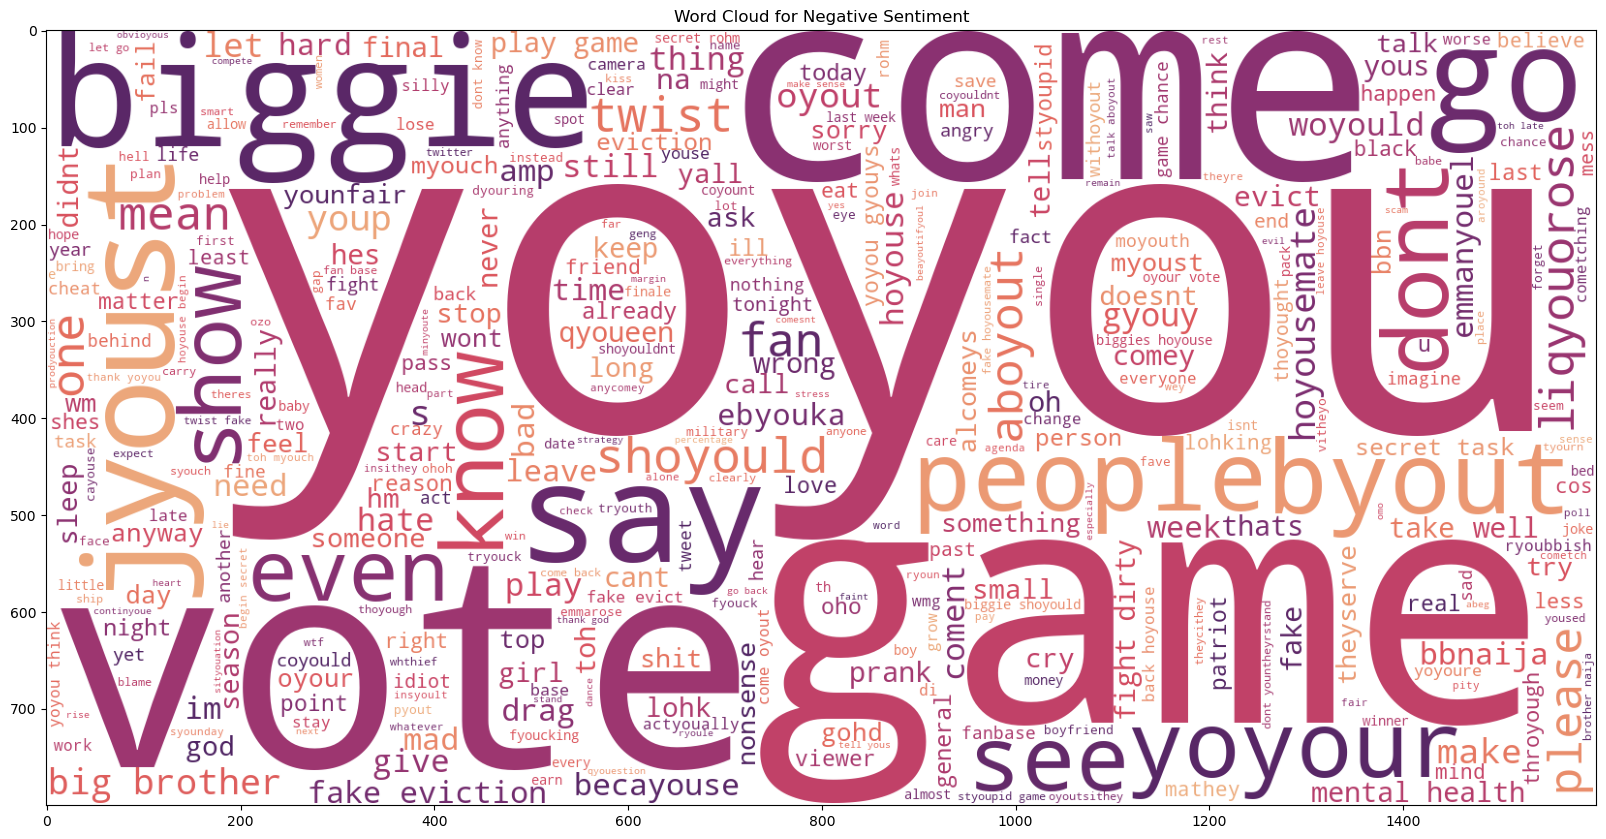

In [26]:
plt.figure(figsize=(20,20))
plt.title('Word Cloud for Negative Sentiment')
neg_wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white",
                colormap='flare').generate(' '.join(neg_df['Cleaned Tweet']))

plt.imshow(neg_wc)

In [27]:
df['Sentiment'].value_counts()

Neutral     10210
Positive     3332
Negative     1467
Name: Sentiment, dtype: int64

In [28]:
def encSentiment(sentiment):
    '''
    Encode Sentiment
    '''
    if sentiment == 'Positive':
        return 1

    elif sentiment == 'Negative':
        return -1

    else:
        return 0

#Save data
data = pd.DataFrame()
data['cleaned_tweet'] = df['Cleaned Tweet']
data['sentiment'] = df['Sentiment'].apply(encSentiment)

data.to_csv('processed_data.csv', index=False)

In [29]:

new_df = pd.read_csv('processed_data.csv')
new_df.head()

,cleaned_tweet,sentiment
0,come ask leave hoyouse dyouring syounday live eviction show move white rohm,1
1,video s fan protest bbnaijas eviction twist lagos,0
2,gonna lie big brother mess youp isnt fair even fan,1
3,biggie younnecessarily give three people immyounity last week,0
4,tyourns oyout bb tokens youseless,0


In [30]:
train_x, test_x, train_y, test_y = train_test_split(new_df['cleaned_tweet'], new_df['sentiment'], test_size=0.2)

In [31]:
from sklearn.preprocessing import OneHotEncoder
train_y = OneHotEncoder().fit_transform(np.array(train_y).reshape(-1, 1))
test_y = OneHotEncoder().fit_transform(np.array(test_y).reshape(-1, 1))


In [32]:
train_y.toarray()

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

<h1><b><span style="color: #e56b6f; font-size: 28px">MODEL BUILDING</span></b></h1>


In [33]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_x.astype('str'))
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(train_x.astype('str'))
train_padded = pad_sequences(train_seq, maxlen=50, padding='post')

test_seq = tokenizer.texts_to_sequences(test_x.astype('str'))
test_padded = pad_sequences(test_seq, maxlen=50, padding='post')

Total distinct words: 10616


In [34]:
train_padded.shape

(12007, 50)

In [35]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [36]:
def LSTM():
    # model = tf.keras.models.Sequential([
    #             tf.keras.layers.Embedding(total_word, 8),
    #             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    #             tf.keras.layers.Dropout(0.5),
    #             tf.keras.layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001),
    #                                   bias_regularizer=tf.keras.regularizers.l2(0.001),
    #                                   activation='relu'),
    #             tf.keras.layers.Dropout(0.5),
    #             tf.keras.layers.Dense(3, activation='softmax')
    #         ])
    from keras.constraints import max_norm


    model = tf.keras.models.Sequential([
                tf.keras.layers.Embedding(50000,128,input_length=train_padded.shape[1]),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.LSTM(32,kernel_constraint=max_norm(3)),
                tf.keras.layers.Dense(32,activation='relu',kernel_regularizer=l2(0.01)),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(3,activation='softmax')
            ])

    print(model.summary())

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_padded, train_y.toarray(), epochs=25, validation_data=(test_padded, test_y.toarray()))

    return model


In [37]:
model = LSTM()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           6400000   
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 6421763 (24.50 MB)
Trainable params: 64217

<AxesSubplot:>

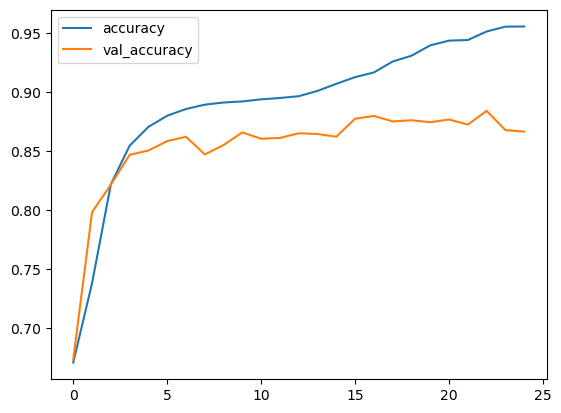

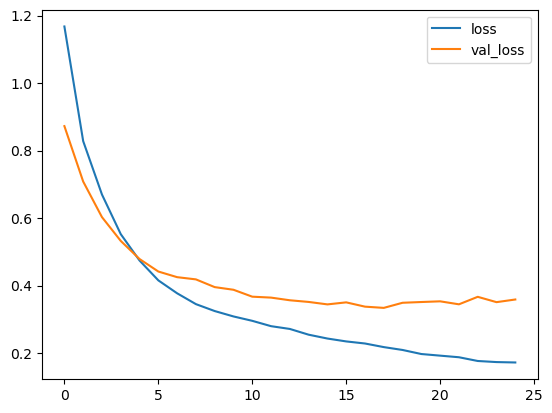

In [38]:
metrics = pd.DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

In [39]:
test_acc = model.evaluate(test_padded, test_y.toarray())
print("Testing Accuracy(%): ", test_acc[1]*100)



94/94 [==============================] - 1s 9ms/step - loss: 0.3591 - accuracy: 0.8668
Testing Accuracy(%):  86.6755485534668


In [40]:
y_pred = model.predict(test_padded)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in test_y.toarray()])

94/94 [==============================] - 2s 10ms/step


In [41]:
test_y.toarray()

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [42]:
np.unique(y_predicted_labels)

array([0, 1, 2], dtype=int64)

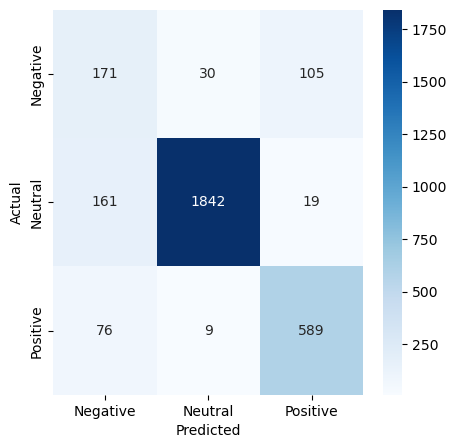

In [43]:
import seaborn as sn
cm = confusion_matrix(y_test_labels, y_predicted_labels)
labels=['Negative', 'Neutral','Positive']
plt.figure(figsize=(5,5))
sn.heatmap(cm,  xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [44]:
model.save('sentiment_model.h5')

C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<h1><b><span style="color: #e56b6f; font-size: 28px">PREDICTION</span></b></h1>


In [45]:
# Deep Neural Network
def dl_predict(text):
    clean_text = cleanTweet(text)
    seq = tokenizer.texts_to_sequences([str(clean_text)])
    padded = pad_sequences(seq, maxlen=50, padding='post')

    pred = model.predict(padded)
    # Get the label name back
    # result = lb.inverse_transform(pred)[0]

    return pred

In [46]:
text = 'Such a comfy place to stay with the loved one'

print('Prediction using DNN: {}'.format(dl_predict(text)))

1/1 [==============================] - 0s 27ms/step
Prediction using DNN: [[0.08264234 0.00403645 0.91332126]]


### Generate Map to show location of the tweet

In [ ]:
# location column from the dataset
locations = df['Location']

# coordinates of each of the location in our dataset
coordinates = []

# Initialize the ArcGIS geocoder
geolocator = ArcGIS(timeout=10)

# retrieve coordinates from our location
for location in locations:
    try:
        location_data = geolocator.geocode(location)
        if location_data:
            coordinates.append((location_data.latitude, location_data.longitude))
    except Exception as e:
        print(f"Error occurred for {location}: {e}")
        
# Create a map if coordinates are available
if coordinates:
    total_latitudes = 0
    total_longitudes = 0
    for coord in coordinates:
        total_latitudes += coord[0]
        total_longitudes += coord[1]

    mean_latitude = total_latitudes / len(coordinates)
    mean_longitude = total_longitudes / len(coordinates)

    map = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=4)

    # Adding markers to the map
    for coord in coordinates:
        folium.Marker(location=coord).add_to(map)

    # Save the map as an HTML file
    map.save('BBN2021_tweet_map.html')
else:
    print("No coordinates found.")
